# Model fit with pipeline



In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the train data
train_data = pd.read_csv('../data/houses_train.csv', index_col=0)

In [3]:
train_data.describe()

,lat,long,zipcode,build_year,living_area,num_rooms,water_percentage_1000,travel_time_private_transport,travel_time_public_transport,number_of_buildings_in_hectare,number_of_apartments_in_hectare,number_of_workplaces_in_hectare,number_of_workplaces_sector_1_in_hectare,number_of_workplaces_sector_2_in_hectare,number_of_workplaces_sector_3_in_hectare,population_in_hectare,price
count,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,2.031300e+04,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,20313.000000,2.031300e+04
mean,47.115240,8.243116,5844.680352,1979.861222,154.635075,4.970260,3.606663e-02,32.633683,53.984739,8.846207,21.186038,2.994437,0.167282,0.719392,2.604539,42.562251,9.614752e+05
std,0.432648,0.785175,2385.369216,63.116038,100.498345,1.952712,8.195149e-02,22.127187,36.625834,5.736250,17.393235,4.802020,0.691818,1.308216,4.503720,39.227625,5.438531e+05
min,45.879650,5.992815,1000.000000,1.000000,17.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.050000e+05
25%,46.871223,7.620374,4104.000000,1972.000000,108.000000,4.000000,1.683527e-07,18.000000,28.000000,5.000000,9.000000,0.000000,0.000000,0.000000,0.000000,16.000000,6.000000e+05
50%,47.259365,8.274725,5722.000000,1992.000000,138.000000,5.000000,4.769363e-03,28.000000,47.000000,8.000000,17.000000,3.000000,0.000000,0.000000,3.000000,32.000000,8.300000e+05
75%,47.441502,8.790168,8231.000000,2010.000000,175.000000,6.000000,2.595080e-02,40.000000,74.000000,12.000000,29.000000,3.000000,0.000000,0.000000,3.000000,57.000000,1.180000e+06
max,47.793530,10.459287,9658.000000,2108.000000,1999.000000,65.000000,6.312276e-01,161.000000,267.000000,79.000000,211.000000,268.000000,6.000000,18.000000,250.000000,467.000000,3.999000e+06


## Prepare data / remove invalid data (deprecated)

In [4]:
# # remove wrong years 
# year_mask = (train_data['build_year'] > 1500) & (train_data['build_year'] < 2023)
# filtered_train_data = train_data[year_mask]

# # remove 0 rooms
# room_zero_mask = (filtered_train_data['num_rooms'] > 0)
# filtered_train_data = filtered_train_data[room_zero_mask]

# # correct rooms with possible missing comma
# rooms_large_mask = filtered_train_data['num_rooms'] < 30
# filtered_train_data = filtered_train_data[rooms_large_mask]


In [5]:
# # convert ZIP into short ZIP
# filtered_train_data['short_zip'] = (filtered_train_data['zipcode'] / 100).astype(int)
# filtered_train_data.head()

In [6]:
# Split data into features and labels.
X_data = train_data.drop(columns='price')
y_data = train_data['price']

In [7]:
# Split features and labels into train (X_train, y_train) and validation set (X_val, y_val).
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, stratify=X_data['object_type_name'], test_size=0.1)

## Predict and evaluate prices for the validation set

After we have trained our model, we will evaluate it on the validation set.

We will use the MAPE metric (https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) for evaluation in this example project.
The MAPE metric is not available in the sklearn.metric package therefore we have implemented it ourselves here.

Note that if you will start your own project, defining which metric to use is an important step.
If you want to learn more about often used metrics that are available in sklearn: https://scikit-learn.org/stable/modules/model_evaluation.html

Note that MAPE is also defined in sklearn (since 2020): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Predict base-line (random mean prediction)

In [9]:
# Note that in this skeleton we do not have a model. Therefore, we predict randomly.
# After you have defined and trained your model in the previous step, you should use it here to make the predictions.
y_val_pred = [np.mean(y_train)] * len(y_val)

# How good are we on the validation data?
# The random predictions from our skeleton are of course quit bad.
print(mean_absolute_percentage_error(y_val, y_val_pred))

53.97803651097174


## Create simple Linear Regression model and calculate prediction

In [10]:
# create pipeline
features_lr_1 = ['living_area', 'num_rooms']

pipeline_lr_1 = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", features_lr_1)
    ], remainder="drop")),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


pipeline_lr_1.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['living_area',
                                                   'num_rooms'])])),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [11]:
# validate model with mean_absolute_percentage_error
y_val_pred = pipeline_lr_1.predict(X_val)
print(mean_absolute_percentage_error(y_val, y_val_pred))

44.06358533508966


<Axes: xlabel='living_area', ylabel='price'>

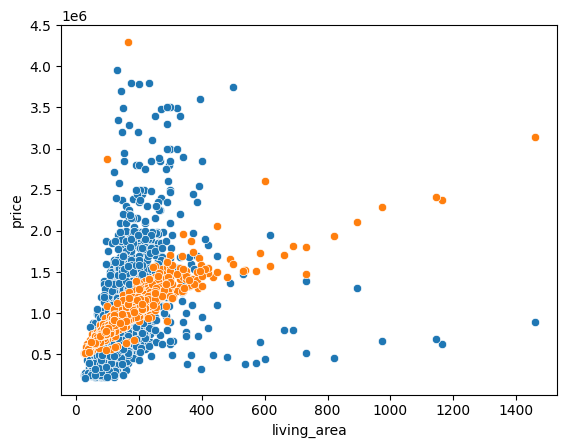

In [12]:
# plot regression model with sns
plt.close()

sns.scatterplot(data=X_val, x='living_area', y=y_val)
sns.scatterplot(data=X_val, x='living_area', y=y_val_pred)

# ValueClipper and RoomCleaner

We use the `ValueClipper` and `RoomCleaner`

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
class ValueClipper(BaseEstimator, TransformerMixin):
    def __init__(self, column, min_threshold, max_threshold):
        self.column = column
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X[self.column] < self.min_threshold, self.column] = self.min_threshold
        X.loc[X[self.column] > self.max_threshold, self.column] = self.max_threshold
        return X

In [16]:
class RoomCleaner(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X.living_area / X.num_rooms < 5, 'num_rooms'] /= 10
        return X

## Regression with all features

In [35]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

def create_short_zipcode(X: pd.DataFrame) -> pd.DataFrame:
    X['short_zip'] = (X['zipcode'] // 100).astype('string')
    return X

# define the features
numerical_features = [
  'living_area',
  'num_rooms',
  'build_year',
]

categorical_features = [
    'short_zip',
    'object_type_name',
    'municipality_name',
]

In [25]:

# Define the preprocessing steps
numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessor and the model into a pipeline
pipeline_lr = Pipeline([
    ('fe_zip_transformer', FunctionTransformer(create_short_zipcode)),
    ('vc', ValueClipper('build_year', 1900, 2020)),
    ('rc', RoomCleaner()),
    ('out', ValueClipper('living_area', 0, 400)),
    # Combine the preprocessing steps
    ('preprocessor', ColumnTransformer(
      transformers=[
          ('num', numerical_preprocessor, numerical_features),
          ('cat', categorical_preprocessor, categorical_features)
      ])),
    ('model', LinearRegression())
])

# Fit the pipeline to the training data
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('fe_zip_transformer',
                 FunctionTransformer(func=<function create_short_zipcode at 0x3040af100>)),
                ('vc',
                 ValueClipper(column='build_year', max_threshold=2020,
                              min_threshold=1900)),
                ('rc', RoomCleaner()),
                ('out',
                 ValueClipper(column='living_area', max_threshold=400,
                              min_threshold=0)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['living_area', 'num_rooms',
                                                   'build_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['short_zip',
                                                   'object_type_name',
                                                   'municipality_name'])])),
                ('model', LinearRegression())])

In [24]:
# validate model with mean_absolute_percentage_error
y_val_pred = pipeline_lr.predict(X_val)
print(mean_absolute_percentage_error(y_val, y_val_pred))

28.35608546288152


## Advanced encoding / feature engineering

In [26]:
class ZipcodeEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['zipcode_3'] = X['zipcode'] // 10  # e.g. 4106 -> 410
        X['zipcode_2'] = X['zipcode'] // 100  # e.g. 4106 -> 41
        X['zipcode_1'] = X['zipcode'] // 1000   # e.g. 4106 -> 4
        return X

In [27]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, degree: int=2):
        super().__init__()
        self.degree = degree
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            for d in range(1, self.degree + 1):
                new_col_name = f"{col}_sqrt_{d}"
                X[new_col_name] = X[col] ** (1 / (2 ** d))
        return X

## Model with Feature Engineering

Let's build a new model and check

In [59]:
lr_model = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [
          'zipcode_3',
          'object_type_name',
          'municipality_name'
        ]),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        (StandardScaler(), ['build_year', 'num_rooms']),

        remainder='drop'
    )),
    # let's use a linear regression model with log-transformed target
    ('reg', TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log,
        inverse_func=np.exp,
    ))
])

lr_model.fit(X_train, y_train)


Pipeline(steps=[('pre_zip', ZipcodeEngineering()),
                ('pre_by_vc',
                 ValueClipper(column='build_year', max_threshold=2020,
                              min_threshold=1900)),
                ('pre_rc', RoomCleaner()),
                ('pre_ohe',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['zipcode_3',
                                                   'object_type_name',
                                                   'municipality_name']),
                                                 ('sqrttransformer-1',
                                                  SqrtTransformer(),
                                                  ['living_area']),
                                                 ('sqrttransformer-2',
                                                  SqrtTransformer(),
                                                  ['travel_time_private_transport']),
                                                 ('sqrttransformer-3',
                                                  SqrtTransformer(),
                                                  ['travel_time_public_transport']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['build_year',
                                                   'num_rooms'])])),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [61]:
y_val_lr_pred = lr_model.predict(X_val)
print(mean_absolute_percentage_error(y_val, y_val_lr_pred))

20.856957792445126


## Show learning curve

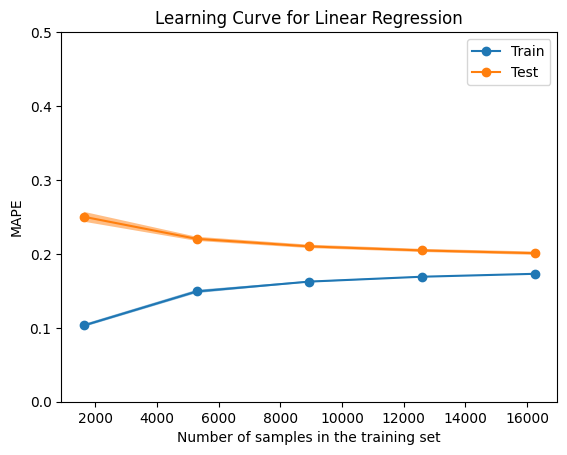

In [62]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params = {
    "X": X_data,
    "y": y_data,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "MAPE",
}
lcd = LearningCurveDisplay.from_estimator(lr_model, **common_params, scoring='neg_mean_absolute_percentage_error', negate_score=True)
lcd.ax_.set_ylim(ymin=0, ymax=0.5)
plt.title("Learning Curve for Linear Regression")
plt.show()

# Let's try model with GradientBoostingRegressor

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [
          'zipcode_3',
          'object_type_name',
          'municipality_name'
        ]),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        (StandardScaler(), ['build_year', 'num_rooms']),

        remainder='drop'
    )),
    # let's use GradientBoostingRegressor
    ('reg', GradientBoostingRegressor(
      n_estimators=100,
      max_depth=10,
      learning_rate=0.2,
      random_state=42
    ))
])

gbr_model.fit(X_train, y_train)

y_val_gbr_pred = gbr_model.predict(X_val)
print(mean_absolute_percentage_error(y_val, y_val_gbr_pred))

22.459209037453963


In [80]:
## let's play around with Grid and Random Search to optimize the hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid
param_grid = {
    'model__regressor__n_estimators': [50, 100, 200],
    'model__regressor__learning_rate': [0.01, 0.1, 1],
    'model__regressor__max_depth': [3, 5, 7]
}

pipeline = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [
          'zipcode_3',
          'object_type_name',
          'municipality_name'
        ]),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        (StandardScaler(), ['build_year', 'num_rooms']),

        remainder='drop'
    )),
    # let's use GradientBoostingRegressor
    # ('model', GradientBoostingRegressor(random_state=42))
    # ('model', GradientBoostingRegressor(random_state=42))
    ('model', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(
          random_state=42
        ),
        func=np.log,
        inverse_func=np.exp,
    ))
])

# Create the grid search
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre_zip', ZipcodeEngineering()),
                                             ('pre_by_vc',
                                              ValueClipper(column='build_year',
                                                           max_threshold=2020,
                                                           min_threshold=1900)),
                                             ('pre_rc', RoomCleaner()),
                                             ('pre_ohe',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['zipcode_3',
                                                                                'object_type_name',
                                                                                'municipality_name']),
                                                                              ('s...
                                                                               ['build_year',
                                                                                'num_rooms'])])),
                                             ('model',
                                              TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                         inverse_func=<ufunc 'exp'>,
                                                                         regressor=GradientBoostingRegressor(random_state=42)))]),
                   param_distributions={'model__regressor__learning_rate': [0.01,
                                                                            0.1,
                                                                            1],
                                        'model__regressor__max_depth': [3, 5,
                                                                        7],
                                        'model__regressor__n_estimators': [50,
                                                                           100,
                                                                           200]},
                   scoring='neg_mean_squared_error')

In [81]:
# Print the best parameters
print(grid_search.best_params_)

{'model__regressor__n_estimators': 200, 'model__regressor__max_depth': 3, 'model__regressor__learning_rate': 1}


In [83]:
# run model with best parameters
gbr_model = Pipeline([
    ('pre_zip', ZipcodeEngineering()),
    ('pre_by_vc', ValueClipper('build_year', 1900, 2020)),
    ('pre_rc', RoomCleaner()),
    ('pre_ohe', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [
          'zipcode_3',
          'object_type_name',
          'municipality_name'
        ]),
        (SqrtTransformer(degree=2), ['living_area']),
        (SqrtTransformer(degree=2), ['travel_time_private_transport']),
        (SqrtTransformer(degree=2), ['travel_time_public_transport']),
        (StandardScaler(), ['build_year', 'num_rooms']),
        # remainder='drop'
    )),
    # let's use GradientBoostingRegressor
    ('reg', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(
          n_estimators=200,
          max_depth=3,
          learning_rate=0.1,
          random_state=42
        ),
        func=np.log,
        inverse_func=np.exp,
    ))
])

gbr_model.fit(X_train, y_train)

y_val_gbr_pred = gbr_model.predict(X_val)
print(mean_absolute_percentage_error(y_val, y_val_gbr_pred))

22.99098574667179
